# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

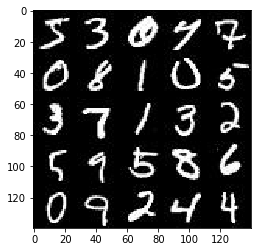

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

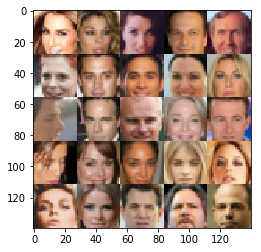

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/ravir/miniconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    learn_rate = tf.placeholder(dtype=tf.float32,shape=())
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """   
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images,64, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(x1 * alpha, x1)
       
        # 14x14x64        
        x2 = tf.layers.conv2d(x1,128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)

        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, kernel_size=5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if batch % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2410... Generator Loss: 0.0229
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 1.8700... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 2.6397... Generator Loss: 0.1311
Epoch 1/2... Discriminator Loss: 2.1118... Generator Loss: 0.2739
Epoch 1/2... Discriminator Loss: 1.9897... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 2.0979... Generator Loss: 0.2773
Epoch 1/2... Discriminator Loss: 2.4108... Generator Loss: 0.2046


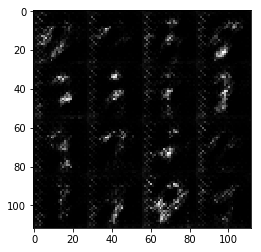

Epoch 1/2... Discriminator Loss: 2.3239... Generator Loss: 0.2394
Epoch 1/2... Discriminator Loss: 2.1734... Generator Loss: 0.3064
Epoch 1/2... Discriminator Loss: 2.1281... Generator Loss: 0.3176
Epoch 1/2... Discriminator Loss: 1.9034... Generator Loss: 0.3709
Epoch 1/2... Discriminator Loss: 2.0951... Generator Loss: 0.3410
Epoch 1/2... Discriminator Loss: 1.9351... Generator Loss: 0.3661
Epoch 1/2... Discriminator Loss: 1.8745... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 1.6937... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.5216
Epoch 1/2... Discriminator Loss: 1.8529... Generator Loss: 0.4396


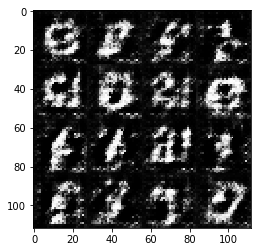

Epoch 1/2... Discriminator Loss: 1.7996... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 1.7429... Generator Loss: 0.5398
Epoch 1/2... Discriminator Loss: 1.5964... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.4764
Epoch 1/2... Discriminator Loss: 1.6610... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 1.6038... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.6594... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.8203... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 1.6498... Generator Loss: 0.4974


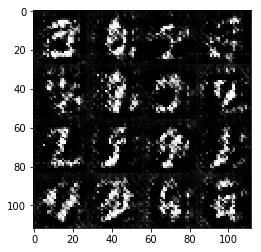

Epoch 1/2... Discriminator Loss: 1.6991... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 1.7778... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 1.7086... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.6193... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.6418... Generator Loss: 0.5530
Epoch 1/2... Discriminator Loss: 1.6547... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.6223... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.5554


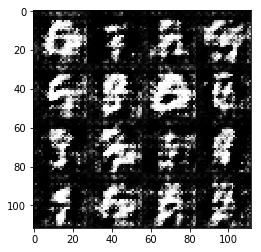

Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.6265... Generator Loss: 0.5497
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 1.6850... Generator Loss: 0.5416
Epoch 1/2... Discriminator Loss: 1.6030... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.5798... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 0.5853


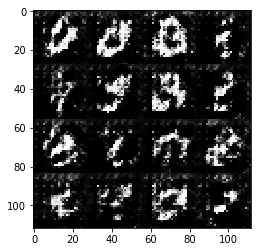

Epoch 1/2... Discriminator Loss: 1.6332... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 1.6166... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.5825
Epoch 1/2... Discriminator Loss: 1.5399... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.6372... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.5968


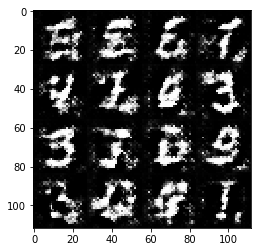

Epoch 1/2... Discriminator Loss: 1.6544... Generator Loss: 0.5369
Epoch 1/2... Discriminator Loss: 1.6808... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.6489... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.5419... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.6373... Generator Loss: 0.5240
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.5801


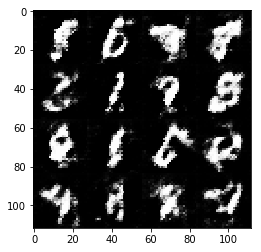

Epoch 1/2... Discriminator Loss: 1.6593... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.6457... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.6411... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.5880
Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.5591


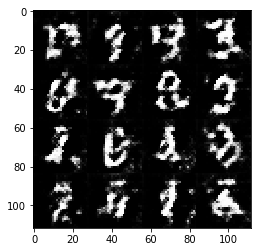

Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.5044... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.6189... Generator Loss: 0.5532
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 0.5728


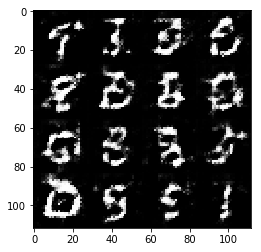

Epoch 1/2... Discriminator Loss: 1.5246... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.7031... Generator Loss: 0.5630
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 0.5267
Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.7450... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.5662... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.5702


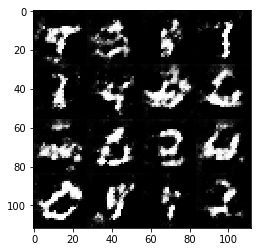

Epoch 1/2... Discriminator Loss: 1.4704... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.5461... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 1.6099... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.5986... Generator Loss: 0.5603


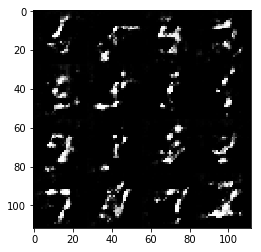

Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.7189... Generator Loss: 0.5002
Epoch 1/2... Discriminator Loss: 1.6298... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.5508... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 1.6329... Generator Loss: 0.5451


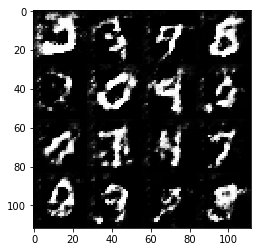

Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.6858... Generator Loss: 0.4809
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.6361... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.5464... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.7035... Generator Loss: 0.5148


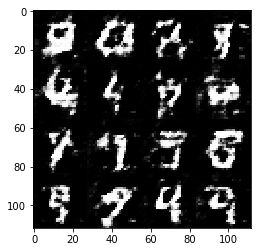

Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.7017... Generator Loss: 0.5303
Epoch 1/2... Discriminator Loss: 1.5425... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.6069... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.6179
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 1.5998... Generator Loss: 0.5393


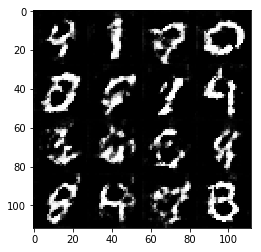

Epoch 1/2... Discriminator Loss: 1.6116... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.4818
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.5524... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.7282... Generator Loss: 0.4789
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.6080


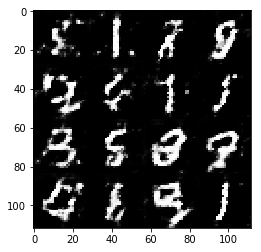

Epoch 1/2... Discriminator Loss: 1.5068... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.6269... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.4519... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.6063... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.5906... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 1.6856... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 1.5826... Generator Loss: 0.5888


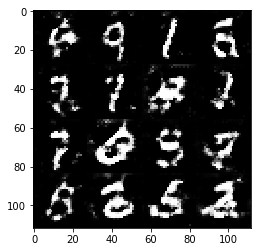

Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.6223... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 1.5362... Generator Loss: 0.5887
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 1.6427... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 1.8505... Generator Loss: 0.3947
Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.5020


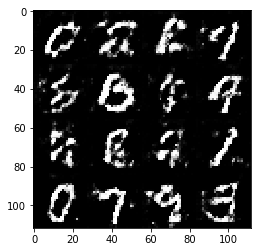

Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 1.7147... Generator Loss: 0.4305
Epoch 1/2... Discriminator Loss: 1.5968... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.5481
Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 0.5375


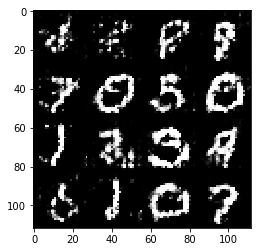

Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.6318... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.5969... Generator Loss: 0.5733
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 1.6488... Generator Loss: 0.5476
Epoch 1/2... Discriminator Loss: 1.5863... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 1.6121... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 0.5909


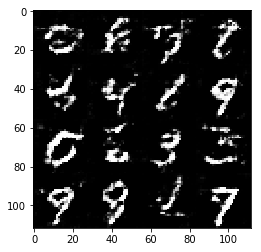

Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 1.5886... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.6181... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 1.5777... Generator Loss: 0.5670
Epoch 2/2... Discriminator Loss: 1.6822... Generator Loss: 0.5068
Epoch 2/2... Discriminator Loss: 1.5269... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 0.5639


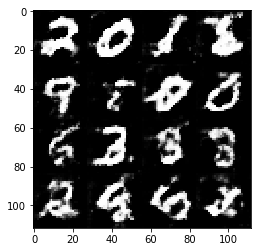

Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 1.6820... Generator Loss: 0.4761
Epoch 2/2... Discriminator Loss: 1.6602... Generator Loss: 0.5735
Epoch 2/2... Discriminator Loss: 1.5979... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 1.5595... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.6535


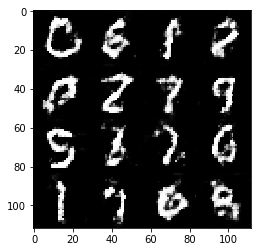

Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.6560
Epoch 2/2... Discriminator Loss: 1.5141... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.6350... Generator Loss: 0.5393
Epoch 2/2... Discriminator Loss: 1.5760... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.5501... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.5244... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.5580... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 1.5044... Generator Loss: 0.5998
Epoch 2/2... Discriminator Loss: 1.4419... Generator Loss: 0.6378


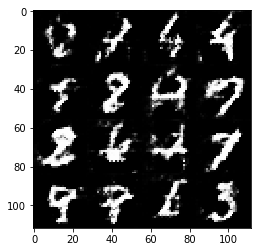

Epoch 2/2... Discriminator Loss: 1.6668... Generator Loss: 0.4724
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 1.5670... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.5892


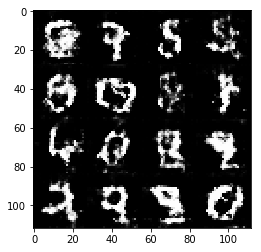

Epoch 2/2... Discriminator Loss: 1.5805... Generator Loss: 0.5700
Epoch 2/2... Discriminator Loss: 1.6859... Generator Loss: 0.4723
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 1.5711... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.6936... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 0.6477
Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.5469... Generator Loss: 0.5677


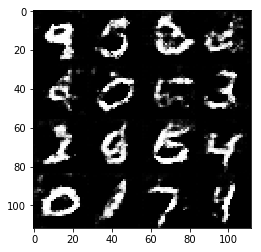

Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 1.5410... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.5513... Generator Loss: 0.5953
Epoch 2/2... Discriminator Loss: 1.5898... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 1.5558... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.6169... Generator Loss: 0.5539
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.5709
Epoch 2/2... Discriminator Loss: 1.6377... Generator Loss: 0.5275


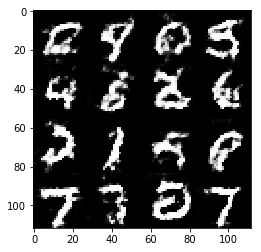

Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.4814... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.4696... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.5960... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.4996... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 1.5016... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.5876... Generator Loss: 0.5558
Epoch 2/2... Discriminator Loss: 1.5420... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.6926... Generator Loss: 0.5159


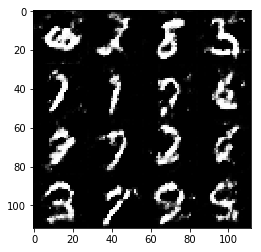

Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 1.6245... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 1.5792... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.5205... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.5152... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.5134... Generator Loss: 0.5748


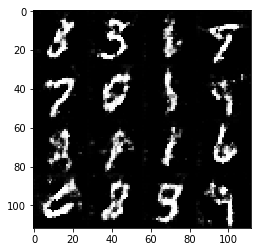

Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.5138... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.6397... Generator Loss: 0.5416
Epoch 2/2... Discriminator Loss: 1.4894... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 1.5975... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.5609... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 0.5863


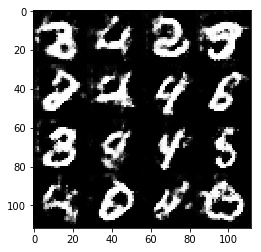

Epoch 2/2... Discriminator Loss: 1.5576... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 1.5640... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.5524... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.5150... Generator Loss: 0.6036
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.5583... Generator Loss: 0.5604
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 0.5858
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.5474... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.6850


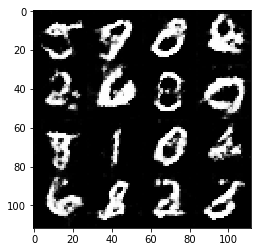

Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 1.5002... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.4937... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.5033... Generator Loss: 0.5969
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 1.6124... Generator Loss: 0.5400
Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.5775
Epoch 2/2... Discriminator Loss: 1.4938... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.5355... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 1.5680... Generator Loss: 0.5823


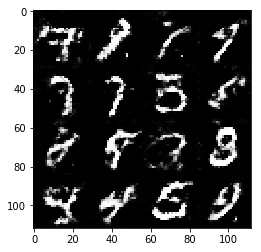

Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.5839
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 1.5075... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6535
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.5933


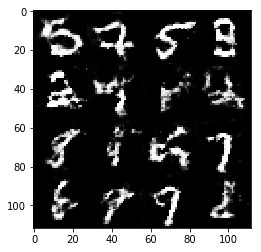

Epoch 2/2... Discriminator Loss: 1.5578... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 1.6991... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.4970... Generator Loss: 0.6014
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.5664... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 1.4813... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.6348


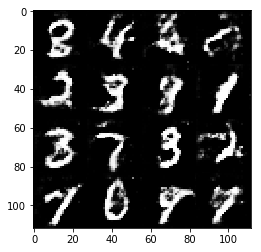

Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.5565... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.5244... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.6306... Generator Loss: 0.5016
Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.5197... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.6161


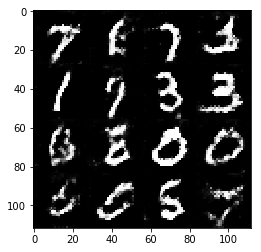

Epoch 2/2... Discriminator Loss: 1.6462... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 1.5520... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.4909... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.4664... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.5875


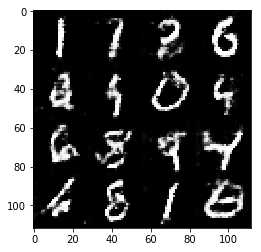

Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.6266
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.5270... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.6154
Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.6373


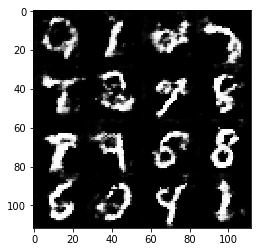

Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.6466
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.5792... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.6273
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.7136


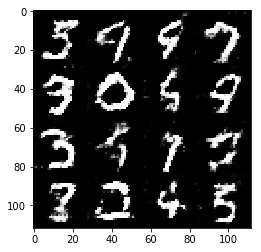

Epoch 2/2... Discriminator Loss: 1.6707... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.6843
Epoch 2/2... Discriminator Loss: 1.4126... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 1.5802... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.6143... Generator Loss: 0.5215


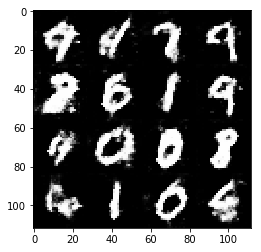

Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.5982
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.5485... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.6015


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 9.4674... Generator Loss: 0.0001
Epoch 1/1... Discriminator Loss: 2.9395... Generator Loss: 0.0881
Epoch 1/1... Discriminator Loss: 3.9627... Generator Loss: 0.0340
Epoch 1/1... Discriminator Loss: 3.1172... Generator Loss: 0.0753
Epoch 1/1... Discriminator Loss: 2.7687... Generator Loss: 0.1485
Epoch 1/1... Discriminator Loss: 2.7487... Generator Loss: 0.1716
Epoch 1/1... Discriminator Loss: 2.2214... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 2.2777... Generator Loss: 0.2381
Epoch 1/1... Discriminator Loss: 2.3972... Generator Loss: 0.2710


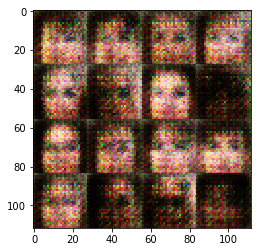

Epoch 1/1... Discriminator Loss: 2.2920... Generator Loss: 0.2864
Epoch 1/1... Discriminator Loss: 2.1834... Generator Loss: 0.2689
Epoch 1/1... Discriminator Loss: 1.9515... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 2.1886... Generator Loss: 0.2850
Epoch 1/1... Discriminator Loss: 2.0874... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 1.9672... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 2.0062... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 2.1757... Generator Loss: 0.3102
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.9323... Generator Loss: 0.3895


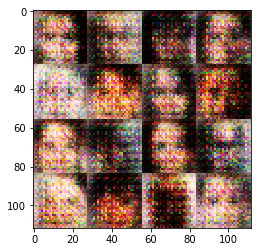

Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.9522... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.8902... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.6461


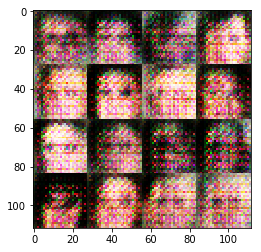

Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.5200


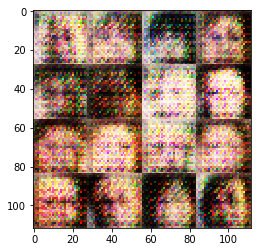

Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.7044


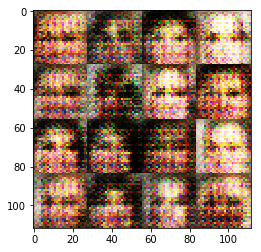

Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.6854... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.6457... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6729


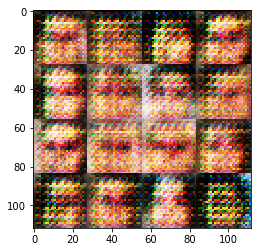

Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.6753


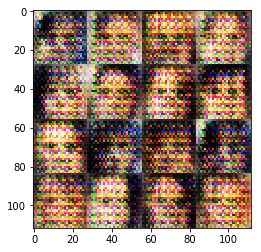

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7577


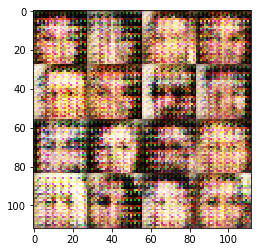

Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.6116


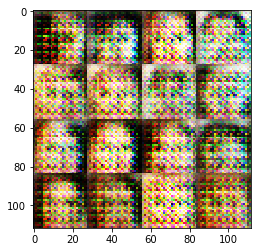

Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7204


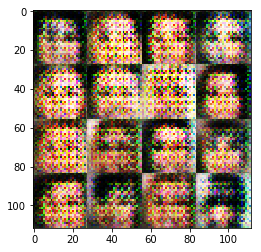

Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6945


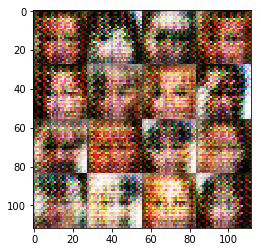

Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7080


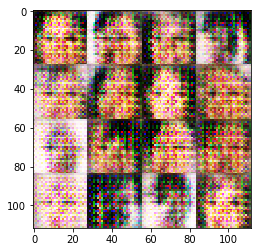

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.6641


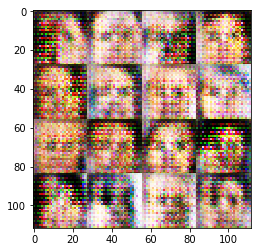

Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7147


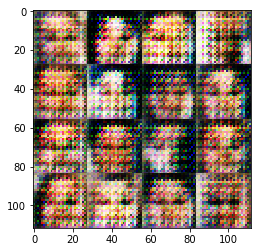

Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.6310


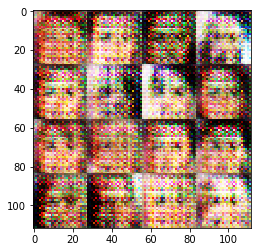

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6799


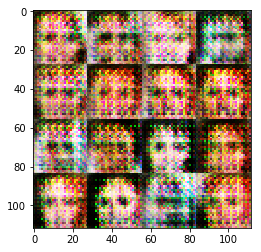

Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.7083


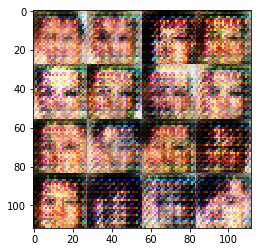

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6387


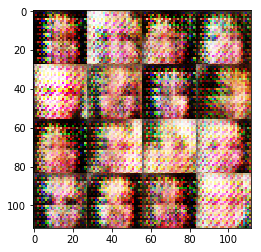

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6105


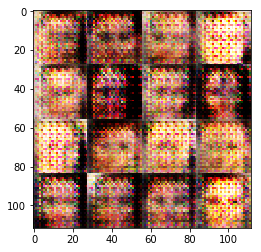

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.6348


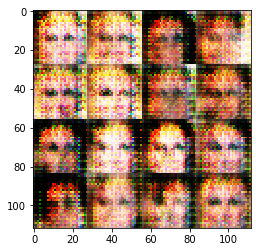

Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.6681... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.4586


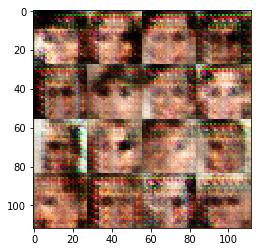

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5858


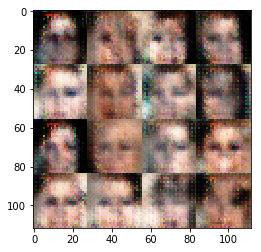

Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6296


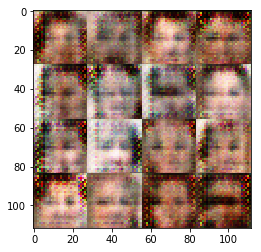

Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7166


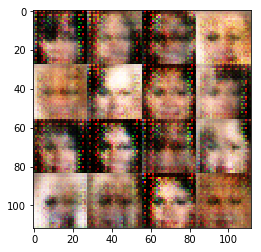

Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7643


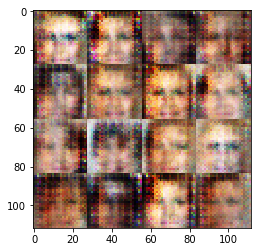

Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7112


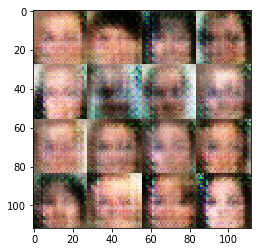

Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6331


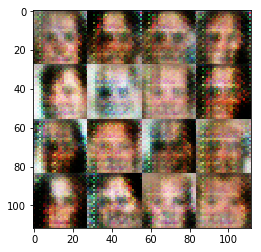

Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7356


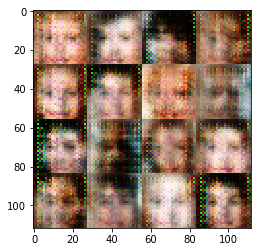

Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.7023


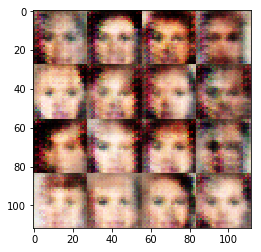

Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.6976... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.6611... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6644


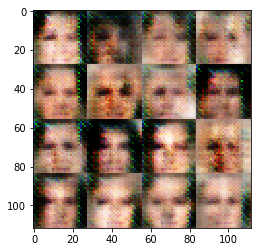

Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6534


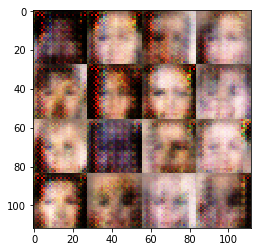

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7165


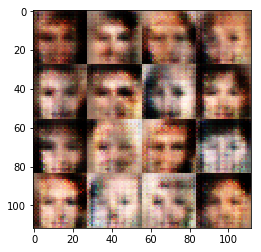

Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.6934... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7287


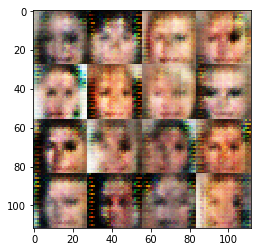

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7303


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.